In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib as plib
import sys
import time
import utils
import cp_optimizer
import math

from ortools.sat.python import cp_model

In [2]:
q_list = ["q1", "q3", "q5", "q4","q2", "q5", "q1"]
df_queries = utils.load(q_list, num_partitions='16')
res = utils.interpolate(df_queries)
precision = 1000
C =16
C_ = None # for split
Q = len(q_list)
R = int(round(Q / 2))
T = cp_optimizer.init_matrix(q_list, res, C, precision)
reg_factor = 0.001
T_arr = np.array(T)
T_min = np.min(T_arr[np.nonzero(T_arr)])
T_min = 0

In [3]:
path_sets_idx = utils.get_path_sets(range(len(q_list)))
num_paths = len(path_sets_idx)
probas = np.random.random(size=num_paths)
probas = list(probas / sum(probas))

# probas = np.ones(num_paths) *1/num_paths
probas_int = utils.probas_to_int(probas, 4)

In [4]:
utils.print_tree(q_list, probas)

                      q1

              q3              q5              

        q4        q2        q5        q1        

    0.299732   0.274216   0.187783   0.238269   


## 1st formulation

In [5]:
#Define program
model = cp_model.CpModel()
#Init Variable
V = {(q, r): model.NewIntVar(0, C, f'V_{q},{r}') for q in range(Q) for r in range(R)}


I = {(q, r): model.NewIntVar(0, R - 1, f'I_{q},{r}') for q in range(Q) for r in range(R)}
X = {q: model.NewIntVar(1, C, f'X_{q}') for q in range(Q)}
k = {r: model.NewIntVar(0, T.max(), f'k_{r}') for r in range(R)}
t_ind = {(q, r): model.NewIntVar(0, T.max(), f't_ind_{q},{r}') for q in range(Q) for r in range(R)}

A = np.zeros((Q, R)).astype(int).astype(object)
for q in range(Q):
    A[q, -1] = X[q]
#V, I, X, k, t_ind, A

#for probability approach
V_bool = {(q, r): model.NewBoolVar(f'V_bool_{q},{r}') for q in range(Q) for r in range(R)}
#TODO : remove after debug
index_run = {q: model.NewIntVar(0, R - 1, f'index_run_{q}') for q in range(Q)}

runtime_runs = {r: model.NewIntVar(T_min, int(T.max() * Q), f'runtime_runs_{r}') for r in range(R)}

runtime_queries = {q: model.NewIntVar(T_min, int(T.max() * Q), f'runtime_queries_{q}') for q in range(Q)}

runtime_paths = {p: model.NewIntVar(T_min, int(T.max() * Q), f'runtime_paths_{q}') for p in range(num_paths)}

variables = V, I, X, k, t_ind, A, (V_bool, index_run, runtime_runs, runtime_queries, runtime_paths)
proba_variables = probas, num_paths, path_sets_idx

max_runtime_path = model.NewIntVar(int(T_min * min(probas_int)), int(T.max() * max(probas_int) * Q), f'max_run_path')

normal_exec = False

In [6]:
#Define program
# 1
for q in range(Q):
    for r in range(R):
        model.AddElement(I[q, r], list(A[q, :]), V[q, r])
    model.AddAllDifferent([I[q, r] for r in range(R)])
# 2
for r in range(R):
    if C_ is None:
        model.Add(sum(V[q, r] for q in range(Q)) <= C)
    else:
        model.Add(sum(V[q, r] for q in range(Q)) == C_)
# 3
for q in range(Q):
    for r in range(R):
        model.AddElement(V[q, r], list(T[q, :]), t_ind[q, r])
for r in range(R):
    model.AddMaxEquality(k[r], [t_ind[q, r] for q in range(Q)])

if probas is None:
    obj = sum(k[r] for r in range(R))
else :
    #Get runtime of each run
    for r in range(R):
        model.Add(runtime_runs[r] == sum(k[rr] for rr in range(r + 1)))
        
    #Get index of which run each query is
    for q in range(Q):
        for r in range(R):
            model.Add(V[q,r] > 0).OnlyEnforceIf(V_bool[q,r])
            model.Add(V[q,r] == 0).OnlyEnforceIf(V_bool[q,r].Not())

            
    for q in range(Q):
        model.Add(index_run[q]==0).OnlyEnforceIf([V_bool[q,r].Not() for r in range(R)]) 
        
        model.Add(runtime_queries[q]==0).OnlyEnforceIf([V_bool[q,r].Not() for r in range(R)]) 
        for r in range(R):
            model.Add(index_run[q]== r).OnlyEnforceIf(V_bool[q,r]) 
            model.Add(runtime_queries[q]== runtime_runs[r]).OnlyEnforceIf(V_bool[q,r]) 
            
        
    #Set path runtime
    for (id_p, path_set) in enumerate(path_sets_idx):
        model.AddMaxEquality(runtime_paths[id_p], [runtime_queries[q] for q in path_set])
    
    if normal_exec:
        print("normal execution")
        obj = sum(probas[p] * runtime_paths[p] for p in range(num_paths))
    else :
        print("alternative execution")
        model.AddMaxEquality(max_runtime_path, [probas_int[p] * runtime_paths[p] for p in range(num_paths)])
        obj = max_runtime_path
    

model.Minimize(obj)

alternative execution


In [7]:
def model_to_solution2(solver, R, variables, proba_variables, q_list, precision, name_queries=True, detailled=False):
    (V, I, X, k, t_ind, A, remain) = variables
    V_bool, index_run, runtime_runs, runtime_queries, runtime_paths = remain
    probas, num_paths, path_sets_idx = proba_variables
    
    Q = len(q_list)
    res_schedule = []
    for r in range(R):
        run_r = []
        for q in range(Q):
            q_r_val = round(solver.Value(V[(q, r)]))
            if q_r_val > 0:
                if name_queries:
                    run_r.append((q_list[q], q_r_val))
                else:
                    run_r.append((q, q_r_val))
        if run_r:
            if detailled :
                res_schedule.append((solver.Value(k[r])/ precision, run_r))
            else: 
                res_schedule.append(run_r)
    runtime = sum(solver.Value(k[r]) for r in range(R))

    if detailled :
        if name_queries : 
            path_time = [([q_list[i] for i in list(path_sets_idx[p])], solver.Value(runtime_paths[p])) for p in range(num_paths)]
        else :
            path_time = [(path_sets_idx[p], solver.Value(runtime_paths[p])/precision) for p in range(num_paths)]
        run_time = [solver.Value(runtime_runs[r])/precision for r in range(R)]
        query_time = [solver.Value(runtime_queries[q])/precision for q in range(Q)]
        return runtime / precision, res_schedule, path_time, run_time, query_time
    else: 
        return runtime / precision, res_schedule

In [8]:
start_time = time.time()
solver = cp_model.CpSolver()
status = solver.Solve(model)
process_time = time.time() - start_time
print(cp_optimizer.MODEL_STATUS[status])
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # (V, _, _, k, _, _) = variables
    runtime, res_schedule = cp_optimizer.model_to_solution(solver, R, V, k, q_list, precision)
else:
    runtime, res_schedule = -1, []

process_time, runtime, res_schedule

OPTIMAL


(0.5099050998687744,
 30.924,
 [[('q1', 8), ('q1', 8)],
  [('q3', 8), ('q4', 4), ('q2', 4)],
  [('q5', 16)],
  [('q5', 16)]])

In [9]:
# [solver.Value(runtime_runs[r]) for r in range(R)]
print("name of the queries : ",[q_list[q] for q in range(Q)])
print("index runs of each query", [solver.Value(index_run[q]) for q in range(Q)])
print("runtime queries : ",[solver.Value(runtime_queries[q]) for q in range(Q)])
print("runtime of each batch : ", [solver.Value(runtime_runs[r]) for r in range(R)])
print("runtime of each path : ", [(path_sets_idx[p], solver.Value(runtime_paths[p])) for p in range(num_paths)])

name of the queries :  ['q1', 'q3', 'q5', 'q4', 'q2', 'q5', 'q1']
index runs of each query [0, 1, 2, 1, 1, 3, 0]
runtime queries :  [4721, 18748, 24836, 18748, 18748, 30924, 4721]
runtime of each batch :  [4721, 18748, 24836, 30924]
runtime of each path :  [({0, 1, 3}, 18748), ({0, 1, 4}, 18748), ({0, 2, 5}, 30924), ({0, 2, 6}, 24836)]


In [10]:
utils.print_tree(q_list, probas, index=False)

                      q1

              q3              q5              

        q4        q2        q5        q1        

    0.299732   0.274216   0.187783   0.238269   


In [11]:
a = model_to_solution2(solver, R, variables, proba_variables, q_list, precision, detailled=True)
runtime, res_schedule, path_time, run_time, query_time = a
print("runtime : ", runtime)
print("schedule : ", res_schedule)
print()
print("path time : ", path_time)
print("runtime each batch: ", run_time)
print("query time : ", query_time)

runtime :  30.924
schedule :  [(4.721, [('q1', 8), ('q1', 8)]), (14.027, [('q3', 8), ('q4', 4), ('q2', 4)]), (6.088, [('q5', 16)]), (6.088, [('q5', 16)])]

path time :  [(['q1', 'q3', 'q4'], 18748), (['q1', 'q3', 'q2'], 18748), (['q1', 'q5', 'q5'], 30924), (['q1', 'q5', 'q1'], 24836)]
runtime each batch:  [4.721, 18.748, 24.836, 30.924]
query time :  [4.721, 18.748, 24.836, 18.748, 18.748, 30.924, 4.721]


## Drawing graphs

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
def batch_to_string(batch):
    time = batch[0]
    schedule = batch[1]
    s = ""
    for q,cores in schedule :
        s +=  q + ":" + str(cores) + ", "
    return s[0:-2] + "\n" + str(time), time

In [68]:
data = {}

for batch in res_schedule:
    s, time = batch_to_string(batch)
    data.update({s:[time]})

data.update({"processes": ["p1"]})
df = pd.DataFrame(data=data)
df = df.melt(id_vars="processes")

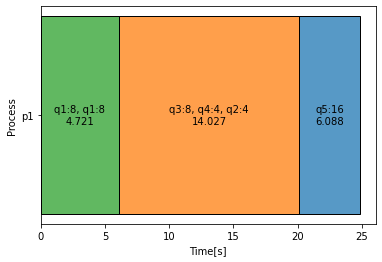

In [75]:
# plot
ax = sns.histplot(data=df, y='processes', hue='variable', weights='value', discrete=True, multiple='stack', legend=False)

# iterate through each container
for i, c in enumerate(ax.containers):

    # Optional: if the segment is small or 0, customize the labels
    # labels = [v.get_width() if v.get_width() > 0 else '' for v in c]
    labels = [df['variable'].tolist()[i]]

    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')

plt.ylabel('Process')
plt.xlabel('Time[s]');

In [20]:
# proba_variables = cp_optimizer.get_proba_variables(q_list, probas)
# process_time, var_results = cp_optimizer.optimize(q_list, res, C, R, precision, proba_variables=proba_variables, reg_factor=reg_factor)

In [21]:
# cp_optimizer.get_program_results(*var_results, True)

## Second formulation test

In [ ]:
#Define program
model = cp_model.CpModel()
#Init Variable
V = {(q, r): model.NewIntVar(0, C, f'V_{q},{r}') for q in range(Q) for r in range(R)}


I = {(q, r): model.NewIntVar(0, R - 1, f'I_{q},{r}') for q in range(Q) for r in range(R)}
X = {q: model.NewIntVar(1, C, f'X_{q}') for q in range(Q)}
k = {r: model.NewIntVar(0, T.max(), f'k_{r}') for r in range(R)}
t_ind = {(q, r): model.NewIntVar(0, T.max(), f't_ind_{q},{r}') for q in range(Q) for r in range(R)}

A = np.zeros((Q, R)).astype(int).astype(object)
for q in range(Q):
    A[q, -1] = X[q]
#V, I, X, k, t_ind, A

#for probability approach
V_bool = {(q, r): model.NewBoolVar(f'V_bool_{q},{r}') for q in range(Q) for r in range(R)}
index_run_q = {q: model.NewIntVar(0, R - 1, f'index_run_{q}') for q in range(Q)}
index_run_path = {p: model.NewIntVar(0, R - 1, f'index_run_{q}') for p in range(num_paths)}
#TODO :check if can reduce range
runtime_runs = {r: model.NewIntVar(T_min, T.max() * Q, f'run_r_{r}') for r in range(R)}

runtime_paths = {p: model.NewIntVar(T_min, T.max() * Q, f'run_path_{q}') for p in range(num_paths)}

In [ ]:
#Define program
# 1
for q in range(Q):
    for r in range(R):
        model.AddElement(I[q, r], list(A[q, :]), V[q, r])
    model.AddAllDifferent([I[q, r] for r in range(R)])
# 2
for r in range(R):
    if C_ is None:
        model.Add(sum(V[q, r] for q in range(Q)) <= C)
    else:
        model.Add(sum(V[q, r] for q in range(Q)) == C_)
# 3
for q in range(Q):
    for r in range(R):
        model.AddElement(V[q, r], list(T[q, :]), t_ind[q, r])
for r in range(R):
    model.AddMaxEquality(k[r], [t_ind[q, r] for q in range(Q)])

if probas is None:
    obj = sum(k[r] for r in range(R))
else :
    #Get index of which run each query is
    for q in range(Q):
        for r in range(R):
            model.Add(V[q,r] > 0).OnlyEnforceIf(V_bool[q,r])
            model.Add(V[q,r] == 0).OnlyEnforceIf(V_bool[q,r].Not())

    for q in range(Q):
        model.Add(index_run_q[q]==0).OnlyEnforceIf([V_bool[q,r].Not() for r in range(R)]) 
        for r in range(R):
            model.Add(index_run_q[q]== r).OnlyEnforceIf(V_bool[q,r]) 
            
    #Get runtime of each run
    for r in range(R):
        model.Add(runtime_runs[r] == sum(k[rr] for rr in range(r + 1)))
        
    #Get index path
    for (p, path_set) in enumerate(path_sets_idx):
        model.AddMaxEquality(index_run_path[p], [index_run_q[q] for q in path_set])
        
    #Get runtime path
    for p in range(num_paths):
        model.AddElement(index_run_path[p], runtime_runs, runtime_paths[p])
        
    obj = sum(probas[p] * runtime_paths[p] for p in range(num_paths)) +  reg_factor *sum(k[r] for r in range(R))

model.Minimize(obj)

In [ ]:
start_time = time.time()
solver = cp_model.CpSolver()
status = solver.Solve(model)
process_time = time.time() - start_time
print(cp_optimizer.MODEL_STATUS[status])
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # (V, _, _, k, _, _) = variables
    runtime, res_schedule = cp_optimizer.model_to_solution(solver, R, V, k, q_list, precision)
else:
    runtime, res_schedule = -1, []

process_time, runtime, res_schedule

In [ ]:
[cp_model.UNKNOWN, cp_model.MODEL_INVALID,   cp_model.FEASIBLE, cp_model.INFEASIBLE, cp_model.OPTIMAL]

## Split proba test

In [ ]:
print_tree(q_list, probas)

In [ ]:
proba_var = cp_optimizer.get_proba_variables(q_list, probas)
R_ = 2
C_ = 2 * len(q_list)
print(C_)
process_time, var_results = cp_optimizer.optimize(q_list, res, C, R=R_, precision=precision, 
                                                  C_=C_,
                                                  proba_variables=proba_var, reg_factor=0.0003
                                                 )
cp_optimizer.get_program_results(*var_results, True)

In [ ]:

probas, num_paths, path_sets_idx = proba_var
_, res_schedule = cp_optimizer.get_program_results(*var_results, False)



In [ ]:
left_queries, _ = zip(*res_schedule[0])
right_queries, _ = zip(*res_schedule[1])
left_queries = set(left_queries)
right_queries = set(right_queries)

# 1. split paths : determine which belong only to left
left_paths = []
right_paths_raw = []
for p in path_sets_idx:
    intersect = p.intersection(right_queries)
    if len(intersect) == 0:
        left_paths.append(p)
    else :
        right_paths_raw.append(p)

# 2. select queries appearing only in right paths
remain_queries = left_queries.intersection(set.union(*left_paths))
left_queries = left_queries.difference(remain_queries)
right_queries = right_queries.union(remain_queries)

# 3. redefine paths right containing queries in left
right_paths = []
for p in right_paths_raw:
    new_p = right_queries.intersection(p)
    right_paths.append(new_p)

# 4. redefine left and right q_list
q_list_left = [q_list[i] for i in sorted(left_queries)]
q_list_right = [q_list[i] for i in sorted(right_queries)]

# Note : need to keep left_queries and right_queries to reconstruct identically